In [12]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

#이미지를 높이 1의 3차원 배열로 바꾸어 전체 배열을 4차원으로 바꾸었다.
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2)

# **합성곱 신경망 만들기**

**첫번째 합성곱층**

In [13]:
model = keras.Sequential()
#kernal_size를 n의 정수로 줄경우 자동으로 입력 데이터의 차원과 동일한 정사각행렬(nXn,nXnXn...)으로 자동으로 설정된다.
#Conv2D의 input_shape를 지정할 땐 배치차원(-1)없이 지정해준다.
#아래의 Conv2D층의 결과로 (28,28,32)크기의 특성맵이 만들어진다.(세임 패딩 사용)
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', 
                             input_shape=(28,28,1)))
#크기 2의 커널을 사용하는 최대 풀링층을 추가
#아래의 MaxPooling2D층의 결과로 (14,14,32)크기의 특성맵이 만들어진다.
model.add(keras.layers.MaxPooling2D(2))
#보통 위의 Conv층과Pooling층을 묶어서 '합성곱 층'이라고 한다.

**두번째 합성곱 층 + 밀집층**

In [14]:
#합성곱층
#64개의 3X3의 커널을 사용
#이 합성곱층의 결과로 (7,7,64) 크기의 특성맵이 만들어진다.
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

#밀집층
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
#과대적합을 막기위해 드롭아웃을 넣는다.
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               313700    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

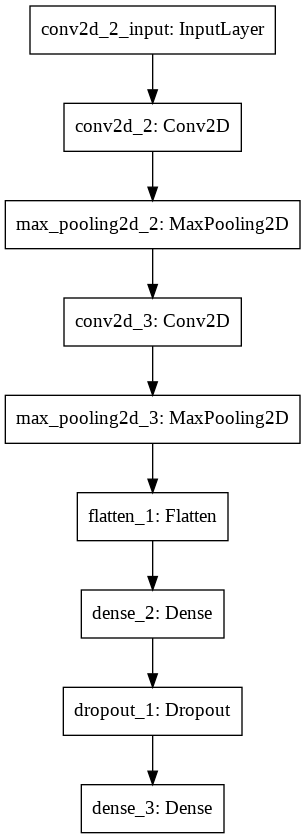

In [15]:
#plot_model메서드는 주어진 모델을 도식화해서 보여준다.
keras.utils.plot_model(model)

**모델 컴파일 및 훈련**

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

#체크포인트및 조기종료 콜백 지정
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.7123 - accuracy: 0.7405 - val_loss: 0.3391 - val_accuracy: 0.8731
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3612 - accuracy: 0.8695 - val_loss: 0.2677 - val_accuracy: 0.9031
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2930 - accuracy: 0.8915 - val_loss: 0.2468 - val_accuracy: 0.9070
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2588 - accuracy: 0.9054 - val_loss: 0.2275 - val_accuracy: 0.9174
Epoch 5/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2320 - accuracy: 0.9129 - val_loss: 0.2290 - val_accuracy: 0.9168
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2133 - accuracy: 0.9210 - val_loss: 0.2355 - val_accuracy: 0.9155


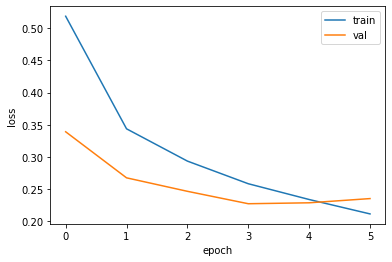

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
#과대적합률이 이전 밀집층만 사용한 신경망보다 훨씬 준 것을 알 수 있다.

In [18]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.2275 - accuracy: 0.9174


[0.22753754258155823, 0.9174166917800903]

**예측**

(28, 28, 1)


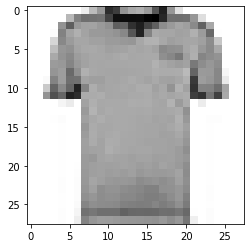

(28, 28, 1)


In [19]:
#아래의 val_scaled[0].reshape는 (28,28,1)의 3차원 배열인 val_scaled[0]을 (28,28)의 2차원배열로 바꿔 출력하기 위함이다.
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [23]:
#val_scaled가 4차원 배열이므로 val_scaled[0:1]은 (1,28,28,1)의 사차원 배열이된다.
print(val_scaled[0:1].shape)
preds = model.predict(val_scaled[0:1])
print(preds)
#predict메서드는 각 출력층 뉴런의 z값을 배열로 반환한다.

(1, 28, 28, 1)
[[9.9911934e-01 2.8749872e-10 1.0731463e-06 8.7103388e-08 1.0305804e-09
  1.2262330e-12 8.7942707e-04 4.7118471e-14 1.6353127e-09 3.0182694e-14]]


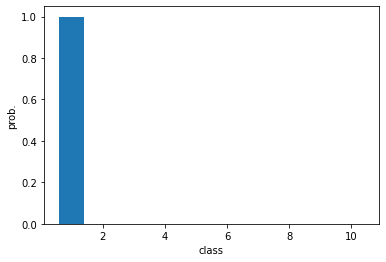

In [24]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [25]:
import numpy as np
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']
#argsmax함수를 이용하여 predict메서드 반환값중 가장 큰 값의 인덱스를 추출한다.
print(classes[np.argmax(preds)])

티셔츠


**테스트 세트 점수**

In [26]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0
model.evaluate(test_scaled, test_target)
#훈련세트의 정확도와 거의 동일하게 나와 과대적합이 많이 해소된, 잘 학습된 모델이 되었음을 알 수 있다.

313/313 [==============================] - 1s 2ms/step - loss: 0.2486 - accuracy: 0.9091


[0.2485862821340561, 0.9090999960899353]